## Practice

**1. Load data**

In [1]:
## read data
congress <- readRDS("../data/uss.rds")
uss <- readRDS("../data/uss-tweets.rds")

## load tidyverse
suppressPackageStartupMessages(library(tidyverse))

## merge data, drop duplicates
uss <- left_join(uss, congress)
uss <- unique(as_tibble(uss))

Joining, by = "user_id"


**2. Clean up the tweets, removing URLs and screen names.**

In [2]:
## remove URLs
uss$text <- stringr::str_replace_all(uss$text, "https?[[:graph:]]+", "")

## remove screen names
uss$text <- stringr::str_replace_all(uss$text, "@\\S+", "")

**3. Conduct sentiment analysis on the tweets by examining the use of POSITIVE words (as described in the "bing" dictionary). Plot the top 20 disproportionately used words by each party (among words used at least twice).**

In [3]:
## load tidytext
library(tidytext)

## tokenize by word
usst <- tidytext::unnest_tokens(uss[, c("user_id", "text", "ideology")], word, text)

## negative words from bing
bing_neg <- get_sentiments("bing") %>%
  filter(sentiment == "negative")

## join with tokenized data and then count
sa <- usst %>%
  mutate(party = ifelse(ideology > .5, "R", "D")) %>%
  inner_join(bing_neg) %>%
  group_by(party) %>%
  count(word, sort = TRUE)

Joining, by = "word"


In [4]:
## remove some domain specific words that shouldn't probably count the way they do
## then identify and pull all words that appear at least once in both groups
sas <- sa %>%
    filter(!word %in% c("trump", "conservative", "liberal") & n > 1) %>%
    group_by(word) %>%
    mutate(tot = n()) %>%
    ungroup() %>%
    filter(tot == 2) %>%
    select(-tot)
## pull the n most used negative words from each group
n <- 20
sas10 <- sas %>%
    spread(party, n) %>%
    mutate(d = D / (D + R)) %>%
    arrange(-d) %>%
    .[c(1:n, (nrow(.) - (n - 1)):nrow(.)), ] %>%
    select(-D, -R) %>%
    mutate(r = 1 - d) %>%
    gather(party, prop, -word) %>%
    mutate(word = factor(word, levels = unique(word)))

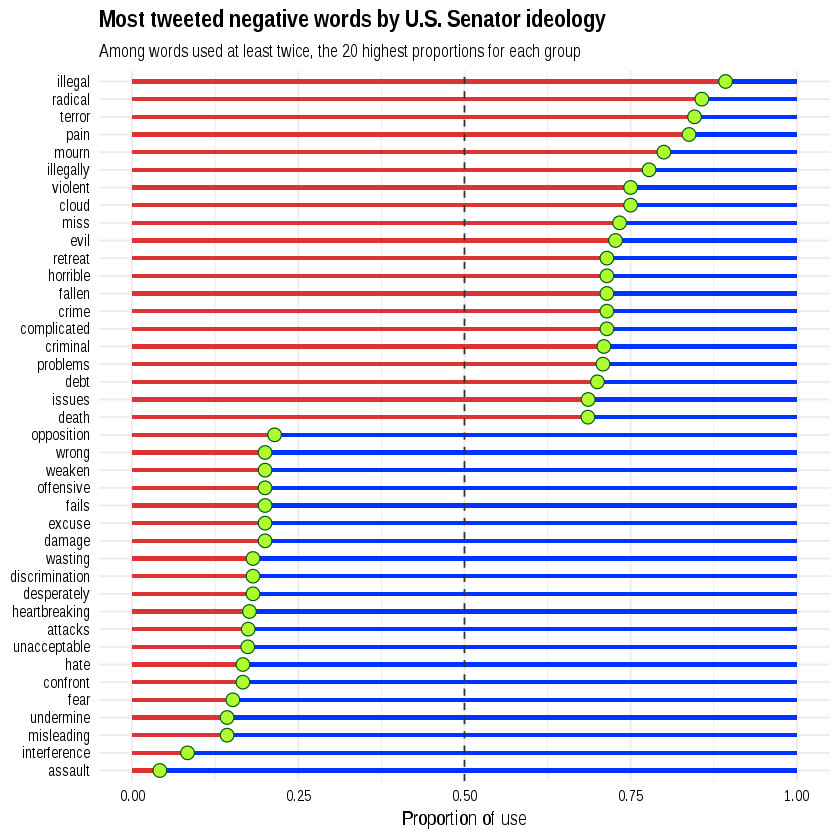

In [5]:
## plot the [filled] proportions using geom_col and stylize with geom_point
sas10 %>%
    ggplot(aes(word, prop, fill = party)) +
    geom_col(width = .25, show.legend = FALSE) +
    labs(y = "Proportion of use", x = NULL,
        title = "Most tweeted negative words by U.S. Senator ideology",
        subtitle = "Among words used at least twice, the 20 highest proportions for each group") +
    coord_flip() + 
    scale_fill_manual(values = c(r = "#dd3333", d = "#0033ff")) + 
    theme_minimal(base_size = 12, base_family = "Arial Narrow") + 
    theme(strip.placement = "outside", 
        plot.title = element_text(face = "bold"),
        axis.text = element_text(colour = "black")) + 
    geom_hline(yintercept = .50, linetype = 2, 
        colour = "gray20") +
    geom_point(data = filter(sas10, party == "r"), aes(y = prop), fill = "greenyellow",
        size = 3.5, shape = 21, colour = "#005511")

**4. Find the top 10 4-word n-grams by party (ideology group)**.

In [6]:
## 4-word ngrams data
ng <- tidytext::unnest_tokens(uss[, c("user_id", "text", "ideology")], 
                              word, text, token = "ngrams", n = 4)

## create party variable, count ngrams and select top 10 for each
ng %>%
    mutate(party = ifelse(ideology > .5, "D", "R")) %>%
    group_by(party) %>%
    count(word, sort = TRUE) %>%
    arrange(party, -n) %>%
    top_n(10, n)

party,word,n
D,i look forward to,58
D,on the senate floor,44
D,state of the union,32
D,thank you for your,30
D,my statement on the,24
D,look forward to working,23
D,pain capable unborn child,21
D,as a result of,20
D,capable unborn child protection,20
D,in the u s,20
